In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb

color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
train = pd.read_csv("train.csv", parse_dates=["timestamp"])

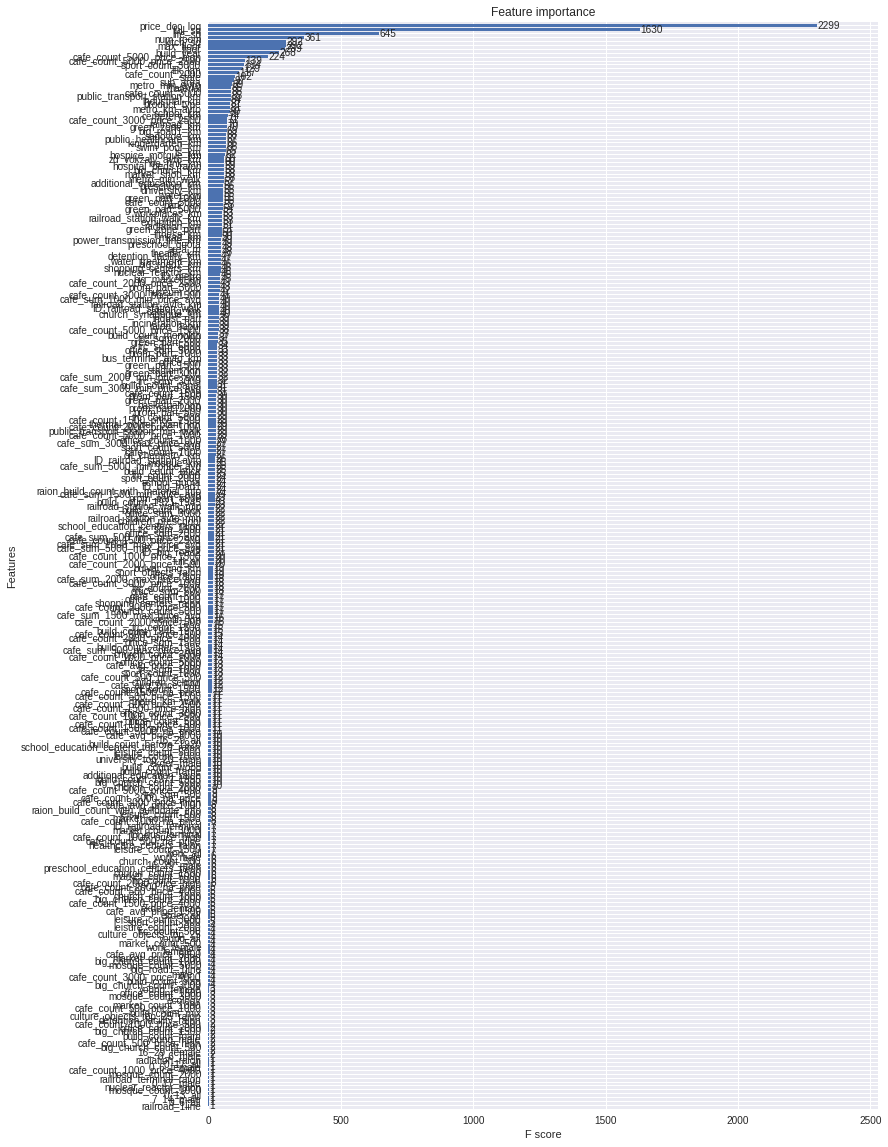

In [23]:
for f in train.columns:
    if train[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values)) 
        train[f] = lbl.transform(list(train[f].values))
        
train_y = train.price_doc.values
train_X = train.drop(["id", "timestamp", "price_doc"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,20))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

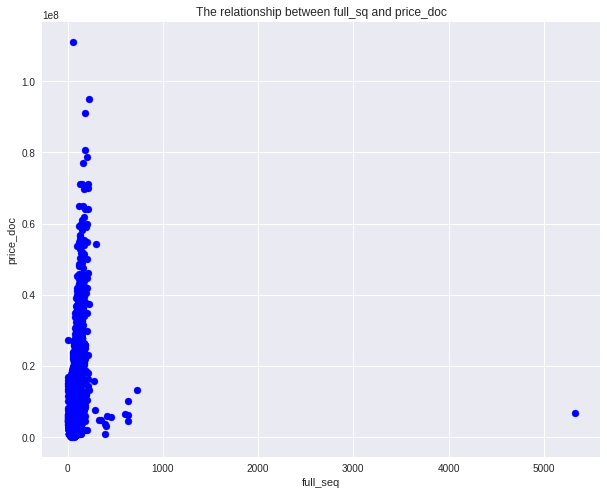

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(x=train["full_sq"], y=train["price_doc"], c="b")
ax.set(title="The relationship between full_sq and price_doc", xlabel="full_seq", ylabel="price_doc")
plt.show()

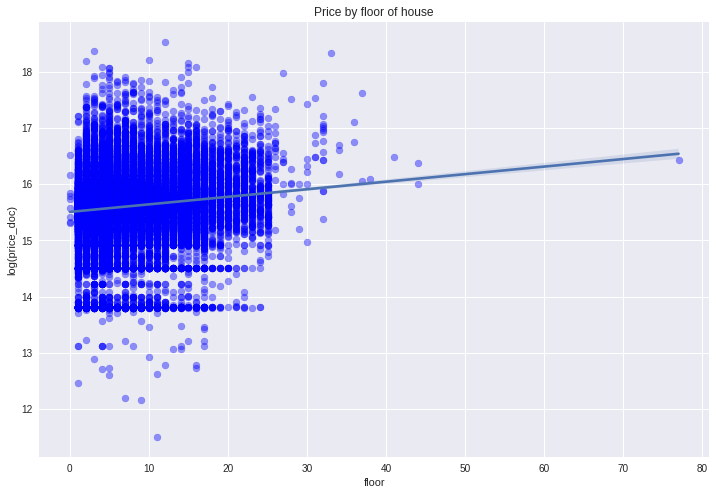

In [21]:
train["price_doc_log"] = np.log1p(train["price_doc"])
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train["floor"], y=train["price_doc_log"], c="b", alpha=0.4)
sns.regplot(x="floor", y="price_doc_log", data=train, scatter=False, truncate=True)
ax.set(title="Price by floor of house", xlabel="floor", ylabel="log(price_doc)")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


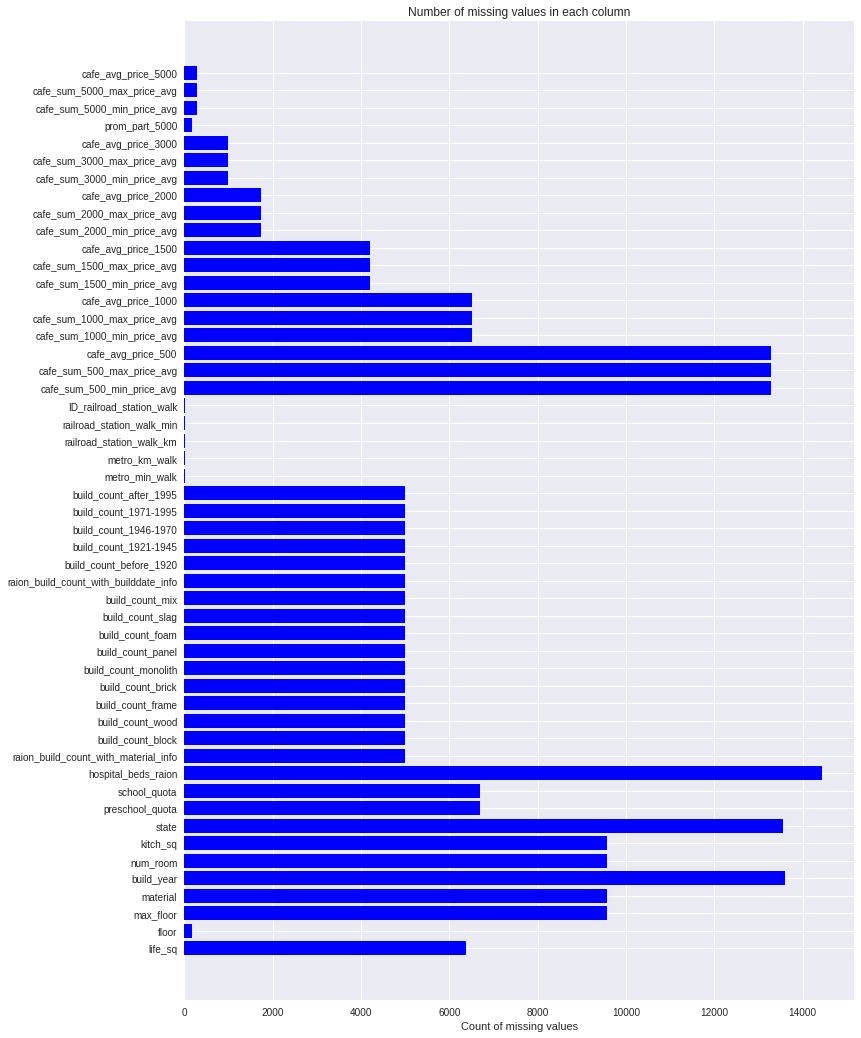

In [24]:
missing = train.isnull().sum(axis=0).reset_index()
missing.columns = ['column_name', 'missing_count']
missing = missing.ix[missing['missing_count']>0]
ind = np.arange(missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing.missing_count.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

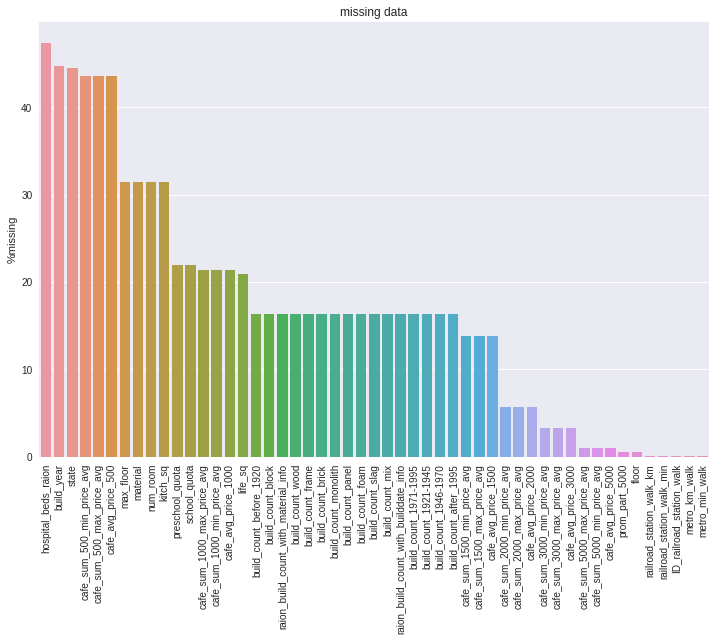

In [26]:
train_null = (train.isnull().sum()/len(train))*100
train_null = train_null.drop(train_null[train_null == 0].index).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation="90")
sns.barplot(x=train_null.index, y=train_null)
ax.set(title="missing data", ylabel="%missing")

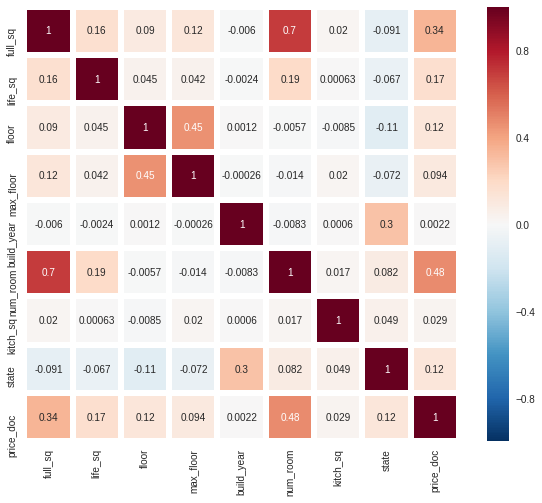

In [35]:
internal_chars=["full_sq", "life_sq", "floor", "max_floor", "build_year", "num_room", "kitch_sq", "state", "price_doc"]
corrmat = train[internal_chars].corr()

fig, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation="90")
sns.heatmap(corrmat, square=True, linewidths=5, annot=True)

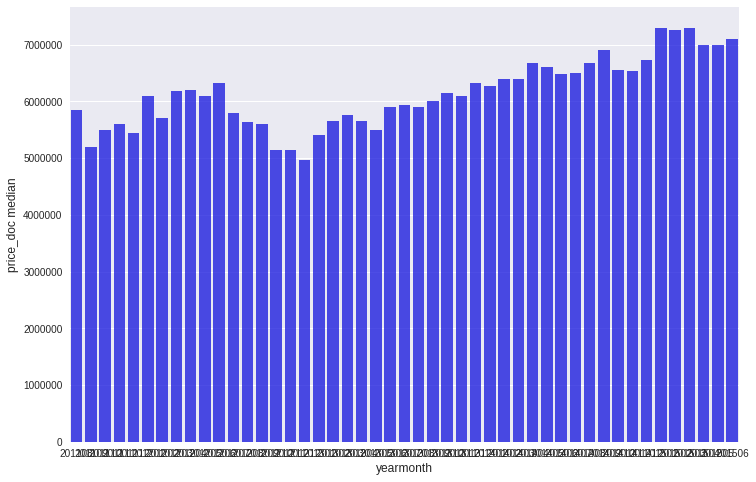

In [45]:
train_df = pd.read_csv("train.csv")
train_df["yearmonth"] = train_df["timestamp"].apply(lambda x: x[:4]+x[5:7])
group = train_df.groupby("yearmonth")["price_doc"].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.barplot(group.yearmonth.values, group.price_doc.values, alpha=0.8, color='b')
plt.xlabel("yearmonth", fontsize=12)
plt.ylabel("price_doc median", fontsize=12)
plt.show()